## Notebook for deploying Cognite Function

### INPUTS

In [1]:
ts_input_name = "VAL_11-LT-95034A:X.Value"
ts_output_name = "VAL_11-LT-95034A:X.CDF.Dummy"#f"VAL_11-LT-95034A:X.D.LeakValue"
tank_volume = 1400
derivative_value_excl = 0.002
# start_date = datetime(2023, 3, 21, 1, 0, 0)
function_name = "dummy_calculation"#"avg_drainage_rate"

data_dict = {'tot_days':0, 'tot_minutes':15, # convert date to str to make it JSON serializable
            'ts_input_name':ts_input_name, 'ts_output_name':ts_output_name,
            'derivative_value_excl':derivative_value_excl, 'tank_volume':tank_volume,
            'cdf_env':"dev", 'dataset_id': 1832663593546318,
            'backfill': False, 'backfill_days': 10,
            'function_name': function_name,
            'lowess_frac': 0.001, 'lowess_delta': 0.01} # NB: change dataset id when going to dev/test/prod!

cron_interval = "15" # 15
cdf_env = "dev"

### Authentication

In [2]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

import os
import sys
import ast
import zipfile

from cognite.client.data_classes import functions

from initialize import initialize_client

func_suffix = "Development"

In [3]:
# Set limit on function calls
func_limits = functions.FunctionsLimits(timeout_minutes=60, cpu_cores=0.25, memory_gb=1, runtimes=["py39"], response_size_mb=2.5)
# I think that timeout_minutes will be capped at 15 anyway ...
client = initialize_client(data_dict["cdf_env"], cache_token=False)

### Function for deploying Cognite Functions in one go

In [ ]:
def deploy_cognite_functions(data_dicts, cdf_env, cron_interval, list_scheduled_calls):
    func_limits = functions.FunctionsLimits(timeout_minutes=60, cpu_cores=0.25, memory_gb=1, runtimes=["py39"], response_size_mb=2.5)
    client = initialize_client(cdf_env, cache_token=False)

    for data_dict in data_dicts:
        folder = os.getcwd().replace("\\", "/")
        folder_cf = folder + "/" + data_dict["function_name"]

        zip_name = "zip_handle.zip"
        zip_path = f"{folder_cf}/{zip_name}"

        with zipfile.ZipFile(zip_path, 'w') as zipf:
            try:
                zipf.write(f'{folder_cf}/requirements.txt', arcname='requirements.txt')
                zipf.write(f'{folder_cf}/../handler_utils.py', arcname='handler_utils.py')
                zipf.write(f'{folder_cf}/handler.py', arcname='handler.py')
                zipf.write(f'{folder_cf}/transformation.py', arcname='transformation.py')
            except:
                raise FileNotFoundError("Make sure you have the following three required files in your Cognite Function folder:\n" \
                                            "\trequirements.txt\n" \
                                            "\thandler.py\n" \
                                            "\ttransformation.py")
        zipf.close()

        uploaded = client.files.upload(path=zip_path, name=zip_name, data_set_id=data_dict["dataset_id"])

        func_create = client.functions.create(
                                            name=f"{data_dict['function_name']}",
                                            external_id=f"{data_dict['function_name']}",
                                            # folder=".",
                                            file_id=uploaded.id,
                                        )

        cognite_function = client.functions.retrieve(external_id=f"{data_dict['function_name']}")

        # Single call to function to run initial transformation before scheduling
        call_cognite_function = cognite_function.call(data=data_dict)

        # AFTER initial call, function can be scheduled
        func_drainage_schedule = client.functions.schedules.create(
            name=f"{data_dict['function_name']}",
            cron_expression=f"*/{cron_interval} * * * *", # every 15 min
            function_id=cognite_function.id,
            #client_credentials=client,
            description=f"Calculation scheduled every {cron_interval} minute",
            data=data_dict
        )

        if list_scheduled_calls:
            my_func = client.functions.retrieve(external_id=data_dict["function_name"])
            my_schedule_id = client.functions.schedules.list(
                        name=data_dict["function_name"]).to_pandas().id[0]
            all_calls = my_func.list_calls(
                        schedule_id=my_schedule_id, limit=-1).to_pandas()
            print(f"Calls for Cognite Function '{my_func.name}':\n{all_calls.tail()}")

### Setup folder structure for Cognite Function

In [4]:
folder = os.getcwd().replace("\\", "/")
folder_cf = folder + "/" + data_dict["function_name"]

zip_name = "zip_handle.zip"
zip_path = f"{folder_cf}/{zip_name}"

# if not os.path.exists(zip_path):
#     open(zip_path, "w").close()

with zipfile.ZipFile(zip_path, 'w') as zipf:
    try:
        zipf.write(f'{folder_cf}/requirements.txt', arcname='requirements.txt')
        zipf.write(f'{folder_cf}/../handler_utils.py', arcname='handler_utils.py')
        zipf.write(f'{folder_cf}/handler.py', arcname='handler.py')
        zipf.write(f'{folder_cf}/transformation.py', arcname='transformation.py')
    except:
        raise FileNotFoundError("Make sure you have the following three required files in your Cognite Function folder:\n" \
                                    "\trequirements.txt\n" \
                                    "\thandler.py\n" \
                                    "\ttransformation.py")
zipf.close()

### Upload file to be associated with your dataset

In [5]:
# os.chdir(data_dict["function_name"])
# zip_name = "zippy_new.zip"
uploaded = client.files.upload(path=zip_path, name=zip_name, data_set_id=data_dict["dataset_id"])

### Deploy Cognite function

In [6]:
# Create function for initial writing (only called once, not on schedule)
func_drainage = client.functions.create(
    name=f"{data_dict['function_name']}",
    external_id=f"{data_dict['function_name']}",
    # folder=".",
    file_id=uploaded.id,
)

In [8]:
func_drainage = client.functions.retrieve(external_id=f"{data_dict['function_name']}")
func_drainage.status
# func_drainage.list_calls().to_pandas()

'Deploying'

In [110]:
# Important! Do single call to function to transform entire time series
# If doing this initial call from schedule it will time out (after ca 15 min)!
call_func_drainage = func_drainage.call(data=data_dict)

### Schedule Cognite function

In [10]:
# AFTER initial call, schedule can be called
func_drainage_schedule = client.functions.schedules.create(
    name=f"{data_dict['function_name']}",
    cron_expression=f"*/{cron_interval} * * * *", # every 15 min
    function_id=func_drainage.id,
    #client_credentials=client,
    description=f"Calculation scheduled every {cron_interval} minute",
    data=data_dict
)

In [7]:
sid = client.functions.schedules.list(function_id=func_drainage.id).to_pandas().id[0]
scid = func_drainage.list_calls(schedule_id=sid, limit=-1).to_pandas()
# resp = func_drainage.retrieve_call(id=scid).get_response()
# pd.to_datetime(scid.iloc[0].scheduled_time, unit="ms")
myid = scid[scid["id"] == 3963540466515989]["id"].iloc[0]
resp = ast.literal_eval(func_drainage.retrieve_call(id=myid).get_response())['VAL_11-LT-95034A:X.Value']
# pd.to_datetime(list(resp.keys())[0], unit="ms")
resp


'null'

In [66]:
my_func = client.functions.retrieve(external_id=data_dict["function_name"])
my_schedule_id = client.functions.schedules.list(
            name=data_dict["function_name"]).to_pandas().id[0]
all_calls = my_func.list_calls(
            schedule_id=my_schedule_id, limit=-1).to_pandas()
all_calls.tail()

,id,start_time,end_time,scheduled_time,status,schedule_id,function_id
264,3527879883784,1699030802847,1699030805148,1699030800000,Completed,1505771999771564,3610320854540928
265,5345632406477003,1699029902035,1699029904289,1699029900000,Completed,1505771999771564,3610320854540928
266,8166367162050530,1699029002012,1699029004254,1699029000000,Completed,1505771999771564,3610320854540928
267,813725456372990,1699028101442,1699028103960,1699028100000,Completed,1505771999771564,3610320854540928
268,6318907194612398,1699027201880,1699027204335,1699027200000,Completed,1505771999771564,3610320854540928


### NB: Delete function

In [13]:
client.functions.delete(id=func_drainage.id)

client.time_series.delete(external_id=f"VAL_11-LT-95034A:X.CDF.D.AVG.LeakValue{func_suffix}")

## Experimental

### Generalizing Cognite Functions - sketch

In [11]:
ts_all = {
        'ts_A': {'name':'A', 'granularity':15, 'var':'a'},
        'ts_B': {'name':'B', 'granularity':10, 'b_specific':[1,2,3]},
        'ts_X': {'name':'X', 'max_days':8, 'thermo_coeff': 0.05, 'filter':'lowess'},
        'ts_Y': {'name':'Y', 'tot_days': 40}
        }

In [ ]:
func_drainage = client.functions.retrieve(external_id="draiange")
func_thermo = client.functions.retrieve(external_id="thermo")

func_drainage_schedule = []
func_thermo_schedule = []

# Create individual schedules for three time series running drainage-Cognite-function
for ts in ['A', 'B', 'Y']:
    func_schedule = client.functions.schedules.create(
        name=f"avg-leak-{ts}",
        cron_expression=f"*/{cron_interval} * * * *",
        function_id=func_drainage.id, # SAME function id
        description=f"Leak rate calculation for time series {ts}",
        data=ts_all[f'ts_{ts}'] # DIFFERENT data dictionaries
    )
    func_drainage_schedule.append(func_schedule)

func_drainage_X = client.functions.schedules.create(
    name=f"avg-leak-X",
    cron_expression=f"*/{cron_interval} * * * *",
    function_id=func_drainage.id,
    description=f"Leak rate calculation for time series X",
    data=ts_all['ts_X'],
)

# Run schedules for DIFFERENT Cognite Functions on SAME time series Y.
# ALTERNATIVE 1: Each one with SAME data dictionary
for func in [func_drainage, func_thermo]:
    func_schedule = client.functions.schedules.create(
        name=f"tsY_{func.name}",
        cron_expression=f"*/{cron_interval} * * * *",
        function_id=func.id, # DIFFERENT function ids
        description=f"{func.name} calculation for time series Y",
        data=ts_all['ts_Y'] # SAME data dictionary
    )
    func_thermo_schedule.append(func_schedule)

# ALTERNATIVE 2: Each one with DIFFERENT data dictionaries
for func in [func_drainage, func_thermo]:
    func_schedule = client.functions.schedules.create(
        name=f"tsY_{func.name}",
        cron_expression=f"*/{cron_interval} * * * *",
        function_id=func.id, # DIFFERENT function ids
        description=f"{func.name} calculation for time series Y",
        data=ts_all[f'ts_Y'][func.name] # DIFFERENT data dictionaries
    )
    func_thermo_schedule.append(func_schedule)


### Testing (NB: move these to `test` folder)

In [86]:
exec("import scipy")

In [88]:
folder = "matplotlib"
exec(f"import {folder}.pyplot as plt")

TypeError: cannot unpack non-iterable Axes object

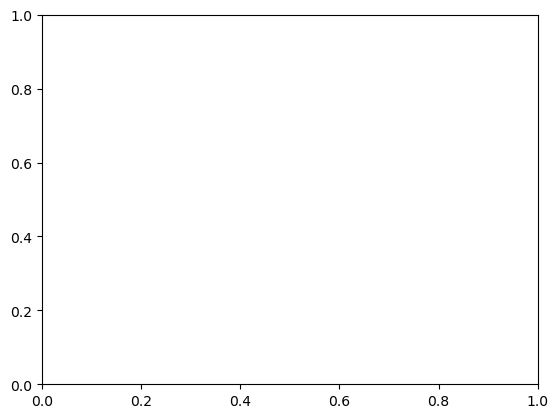